In [46]:
import numpy as np
import math
import cmath
import matplotlib.pyplot as plt

from scipy.linalg import expm

from qiskit import transpile
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Pauli
from qiskit.circuit.library import UnitaryGate, QFT

from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_aer import AerSimulator
pi = np.pi

In [ ]:
def create_hamiltonian(qubits, g, quiet=False):
    H = np.zeros((2**qubits, 2**qubits), dtype=np.complex128)

    # construct the Hamiltonian
    # with Pauli Operators in Qiskit ^ represents a tensor product
    if not quiet: print("H = ", end='')
    for i in range(qubits-1):
        temp = Pauli('')
        for j in range(qubits):
            if (j == i or j == i+1):
                temp ^= Pauli('Z')
            else:
                temp ^= Pauli('I')
        if not quiet: print("-"+str(temp)+" ", end='')
        H += -temp.to_matrix()
    for i in range(qubits):
        temp = Pauli('')
        for j in range(qubits):
            if (j == i):
                temp ^= Pauli('X')
            else:
                temp ^= Pauli('I')
        if not quiet: print("-"+str(g)+"*"+str(temp)+" ", end='')
        H += -g*temp.to_matrix()
    if not quiet: print("\n")
    scale_factor = pi*3/4
    # normalize the Hamiltonian (not needed here)
    H = scale_factor*H/np.linalg.norm(H, ord=2)
    
    # # rotate matrix so that it will be positive definite
    # H += pi*np.eye(2**qubits)

    if not quiet: print("Eigenvalues of the Hamiltonian:\n", np.linalg.eigvals(H))
    min_eigenvalue = np.min(np.linalg.eigvals(H))
    if not quiet: print("Lowest energy Eigenvalue", min_eigenvalue); print()

    return H

def run_hadamard_test(ham, t):
    # # just for testing
    # Ham  = np.array([[1,0], [0, np.exp(1j*pi)]])
    qr_ancilla = QuantumRegister(1)
    qr_eigenstate = QuantumRegister(np.log2(Ham[0].shape[0]))
    cr = ClassicalRegister(1)
    qc = QuantumCircuit(qr_ancilla, qr_eigenstate, cr)
    qc.h(qr_ancilla)
    # qc.x(qr_eigenstate)
    mat = expm(1j * Ham*t)
    controlled_U = UnitaryGate(mat).control(annotated="yes")
    qc.append(controlled_U, qargs = [qr_ancilla[:]] + qr_eigenstate[:] )
    qc.h(qr_ancilla)
    qc.measure(qr_ancilla[0],cr[0])
    # print(qc)
    aer_sim = AerSimulator()
    trans_qc = transpile(qc, aer_sim)
    Nsample = 100
    counts = aer_sim.run(trans_qc, shots = Nsample).result().get_counts()
    
    re_p0 = 0
    if counts.get('0') is not None:
        re_p0 = counts['0']/Nsample
    
    Re = 2*re_p0-1

    return Re


In [107]:
data_points = 100
t_list = np.linspace(0,2*pi, data_points)
# print(t_list)
Ham = create_hamiltonian(2, 0)
phases = []
for t in t_list:
    if t == 0: continue
    phase = math.acos(run_hadamard_test(Ham, t))
    # print(t,t%(2*pi))
    if t % (2*pi) > pi:
        phase = 2*pi-phase
    phase = phase/t
    phases.append(phase)
    # print("phase is", phase)


[0.         0.06346652 0.12693304 0.19039955 0.25386607 0.31733259
 0.38079911 0.44426563 0.50773215 0.57119866 0.63466518 0.6981317
 0.76159822 0.82506474 0.88853126 0.95199777 1.01546429 1.07893081
 1.14239733 1.20586385 1.26933037 1.33279688 1.3962634  1.45972992
 1.52319644 1.58666296 1.65012947 1.71359599 1.77706251 1.84052903
 1.90399555 1.96746207 2.03092858 2.0943951  2.15786162 2.22132814
 2.28479466 2.34826118 2.41172769 2.47519421 2.53866073 2.60212725
 2.66559377 2.72906028 2.7925268  2.85599332 2.91945984 2.98292636
 3.04639288 3.10985939 3.17332591 3.23679243 3.30025895 3.36372547
 3.42719199 3.4906585  3.55412502 3.61759154 3.68105806 3.74452458
 3.8079911  3.87145761 3.93492413 3.99839065 4.06185717 4.12532369
 4.1887902  4.25225672 4.31572324 4.37918976 4.44265628 4.5061228
 4.56958931 4.63305583 4.69652235 4.75998887 4.82345539 4.88692191
 4.95038842 5.01385494 5.07732146 5.14078798 5.2042545  5.26772102
 5.33118753 5.39465405 5.45812057 5.52158709 5.58505361 5.648520

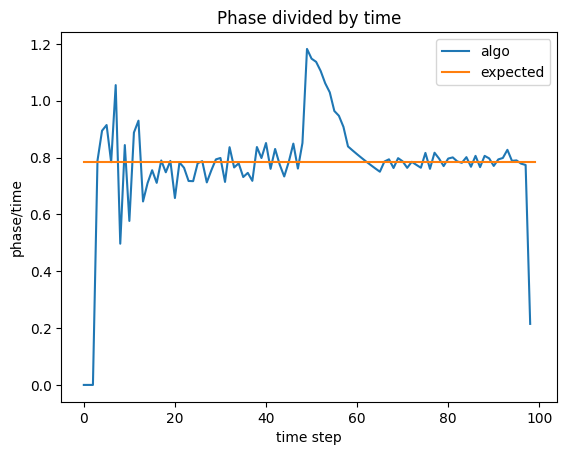

In [108]:
real_phase = [np.linalg.eigvals(Ham)[0].real for _ in range(data_points)]
plt.title("Phase divided by time")
plt.xlabel("time step")
plt.ylabel("phase/time")
plt.plot(phases, label = "algo")
plt.plot(real_phase, label = "expected")
plt.legend()
plt.show()

In [112]:
def generate_s_k(ham, k, Dt, K):
    # use real hadmard test to generate data
    s_k = [0 for _ in range(2*K+1)]
    for i in range(2*K+1):
        # print("generating s_k for Dt:", (i+1)*Dt)
        s_k[i] = run_hadamard_test(ham, (i+1)*Dt)
    # print(s_k)
    return s_k

def make_X(start, K, d, s_k = []):
    X = np.zeros((d, K+1))
    for i in range(len(X)):
        for j in range(len(X[i])):
            X[i][j] = s_k[i+j+start]
    return X

def regression(X, noise_threshold):
    # print("X", X)
    U, sigma, V = np.linalg.svd(X)
    threshold = noise_threshold*max(sigma)
    # print("U", U)
    # print("sigma", sigma)
    # print("V", V)
    for l in range(len(sigma)):
        # print("iteration")
        # print("sigma_l", sigma[l])
        if sigma[l] <= threshold:
            # print("    too small\n")
            sigma[l] = 0
            U[:,l] = 0
            V[:,l] = 0
    sigma_mat = np.zeros((U.shape[1], V.shape[0]))
    for l in range(len(sigma)):
        sigma_mat[l][l] = sigma[l]
    # print("U\n", U)
    # print("sigma\n", sigma_mat)
    # print("V\n", V.conj().T)
    return U @ sigma_mat @ V.conj().T

'''
Dt: time step for each iteration (Dt should not be small)
noise_threshold: used for linear regression
err_threshold: how close the energy until iterations have been stopped
K: number of time steps to take each
alpha: used for calculating d  
'''
est_E_0s = []
def ODMD(ham, Dt, noise_threshold, err_threshold, K = 3, alpha = 1/2): 
    k = 0
    # this is the suggested formula
    # d = math.floor(alpha*(K+1))
    d=3
    while (True):
        print(k)
        s_k = generate_s_k(ham, k, Dt, K)
        X = make_X(0, K, d, s_k=s_k)
        print("X\n",X)
        Xprime = make_X(1, K, d, s_k=s_k)
        print("Xprime\n",Xprime) 
        X_sigma = regression(X, noise_threshold)
        print("X_sigma\n",X_sigma)  
        A = Xprime @ np.linalg.pinv(X_sigma)
        print("A\n",A)  
        k = k+1
        eigenvalues,_ = np.linalg.eig(A)
        print("eigenvalues\n", eigenvalues)
        # I don't know if I am doing this right (I log?)
        eigenlogs = [math.atan2(i.imag, i.real) for i in eigenvalues]
        print("eigenlogs\n", eigenlogs)
        E_0 = -max(eigenlogs, key=abs)/Dt
        print("E_0 =", E_0)
        try:
            if abs(old_E_0 - E_0) < err_threshold:
                print("it stopped here")
        except:
            True
        finally:
            est_E_0s.append(E_0)
            old_E_0 = E_0
        if k>20:
            break
    return E_0

Ham = create_hamiltonian(2, 0)
print(Ham)
ODMD(Ham, 2*pi/100, .000001, 0.1)

H = -ZZ -0*XI -0*IX 

Eigenvalues of the Hamiltonian:
 [0.78539816+0.j 5.49778714+0.j 5.49778714+0.j 0.78539816+0.j]
Lowest energy Eigenvalue (0.7853981633974483+0j)

[[0.78539816+0.j 0.        +0.j 0.        +0.j 0.        +0.j]
 [0.        +0.j 5.49778714+0.j 0.        +0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 5.49778714+0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 0.78539816+0.j]]
0
X
 [[1.   1.   1.   0.94]
 [1.   1.   0.94 1.  ]
 [1.   0.94 1.   0.98]]
Xprime
 [[1.   1.   0.94 1.  ]
 [1.   0.94 1.   0.98]
 [0.94 1.   0.98 0.98]]
X_sigma
 [[ 0.99509909  0.03010854  0.11926876 -1.69653949]
 [ 0.97700694  0.09074856  0.17569197 -1.69998661]
 [ 1.02803537  0.08485361  0.11555934 -1.6633067 ]]
A
 [[-25.86716147   6.25565138  19.58628449]
 [-25.23269146   6.53582133  18.67677276]
 [-25.71864398   7.03809061  18.64521666]]
eigenvalues
 [-0.46560639+0.80128033j -0.46560639-0.80128033j  0.2450893 +0.j        ]
eigenlogs
 [2.0971864060282677, -2.097186406028

-33.10194296036056

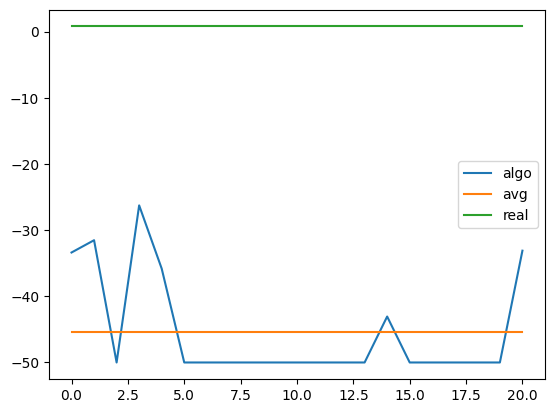

In [113]:
real_E_0 = [np.linalg.eigvals(Ham)[0].real for _ in range(len(est_E_0s))]
avg_E_0 = [np.average(est_E_0s) for _ in range(len(est_E_0s))]

test = np.array(est_E_0s)
plt.plot(est_E_0s, label = "algo")
plt.plot(avg_E_0, label = "avg")
plt.plot(real_E_0, label = "real")
plt.legend()
plt.show()